In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
from sklearn.preprocessing import robust_scale, scale, minmax_scale, quantile_transform
from scipy import stats
%matplotlib inline

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

Initially I had scaled and one hot coded a lot of the variables. But when I was starting to classify the offers I found it difficult to verify my logic was correct. It was overly complicated when I was spot checking certain events. So I will do minimal manipulation before classifying the orders. And then scale, one hot code, etc. after classifying.  

Most my decisions for data preperation were made during the data exploration phase

 <font size="5"> portfolio </font>

All channels contain 'email' so it wont be informative. Removing it makes things clearer and also it is good to cut down on features that dont contain useful information before building our model.

In [3]:
for row in portfolio.channels:
    row.remove('email')    

I will parse out the channel column and one hot encode the offer type after classification

 <font size="5"> transcript </font>

Preparing transcript table in the same way it was done in the Data_Exploration notebook

In [4]:
value_col=transcript.pop('value')

value_col=pd.DataFrame.from_records(data=value_col,columns=['offer id','offer_id','amount','reward'])

value_col['offer id'].update(value_col.pop('offer_id'))

transcript= transcript.join(value_col)

transcript.rename(columns={"offer id": "offer_id"},inplace=True)

display(transcript.groupby(['event']).count())

,person,time,offer_id,amount,reward
event,,,,,
offer completed,33579,33579,33579,0,33579
offer received,76277,76277,76277,0,0
offer viewed,57725,57725,57725,0,0
transaction,138953,138953,0,138953,0


Joining portfolio to transcript as was done in data exploration

In [5]:
portfolio.rename(columns={"id": "offer_id"},inplace=True)

transcript_portfolio=transcript.merge(portfolio,on=('offer_id' ),how='left')


#Instead of removing one of the columns, I am keeping both for now
#renaming reward to reward_recieved from transcript. and reward from portfolio will be kept as reward.
transcript_portfolio.rename(columns={"reward_x": "reward_received","reward_y": "reward"},inplace=True)


transcript_portfolio.head()

,person,event,time,offer_id,amount,reward_received,reward,channels,difficulty,duration,offer_type
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,5.0,"[web, mobile]",5.0,7.0,bogo
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,5.0,[web],20.0,10.0,discount
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,2.0,"[web, mobile]",10.0,7.0,discount
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,2.0,"[web, mobile, social]",10.0,10.0,discount
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,10.0,"[web, mobile, social]",10.0,5.0,bogo


In [6]:
#transcript_portfolio.query('event == "offer received"')

reward and reward_receieved are identical where event==offer_completed.  
reward_received is null where event!='offer_completed'.  
So i will remove 'reward received' as it holds no additonal data that 'reward' doesnt. I am aware it only is awarded when 'offer_completed' but I would like to have the information there for the offer regardless of event.

In [7]:
#display(transcript[transcript.event=='offer received'].head(2))

display(transcript_portfolio[transcript_portfolio.event=='offer completed']['reward'].equals(transcript_portfolio[transcript_portfolio.event=='offer completed']['reward_received']))

display(transcript_portfolio[transcript_portfolio.event!='offer completed']['reward_received'].unique())

transcript_portfolio.drop(['reward_received'], axis=1, inplace=True)


True

array([nan])

In [8]:
transcript_portfolio.head()

,person,event,time,offer_id,amount,reward,channels,difficulty,duration,offer_type
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5.0,"[web, mobile]",5.0,7.0,bogo
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,5.0,[web],20.0,10.0,discount
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,2.0,"[web, mobile]",10.0,7.0,discount
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,2.0,"[web, mobile, social]",10.0,10.0,discount
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,10.0,"[web, mobile, social]",10.0,5.0,bogo


Analysing the amount column 

In this project the amount a customer spends is not a feature in the same sense that reward, difficulty, duration, offer_type, or channels is. It is just a precursor to an event being triggered and set to successful or not. So it is not necessary for me prepare or scale the data in the same way.  

Although it is important that I examime this data to make sure it is not junk data or that there is nothing suspicious going on.

In [9]:
display(transcript_portfolio.groupby('amount').count().head(5))
display(transcript_portfolio.groupby('amount').count().tail(5))

,person,event,time,offer_id,reward,channels,difficulty,duration,offer_type
amount,,,,,,,,,
0.05,431,431,431,0,0,0,0,0,0
0.06,109,109,109,0,0,0,0,0,0
0.07,89,89,89,0,0,0,0,0,0
0.08,100,100,100,0,0,0,0,0,0
0.09,87,87,87,0,0,0,0,0,0


,person,event,time,offer_id,reward,channels,difficulty,duration,offer_type
amount,,,,,,,,,
977.78,1,1,1,0,0,0,0,0,0
989.34,1,1,1,0,0,0,0,0,0
1001.85,1,1,1,0,0,0,0,0,0
1015.73,1,1,1,0,0,0,0,0,0
1062.28,1,1,1,0,0,0,0,0,0


For reasons explained in the data exploration phase I will remove transactions of less than 25cents.

In [10]:
transcript_portfolio=transcript_portfolio.loc[~(transcript_portfolio.amount<0.25)]

I tested my classification logic on the informational offers in the scenario where I did and did not filter out the values less than 25 cents.  

Before filtering:
* unsuccessful_offer: 9439
* successful_offer: 5796

After filtering:
* unsuccessful_offer: 9492
* successful_offer: 5743

So 53 offers moved from successful to successful. This is about 0.34% of all the informational offers. So I am happy that I am not changing the results too much in the case that my reasoning for the filtering is misguided. And I still think it will need to a small improvment in the algorithm.  

I did also confirm to myself that the classification of bogo and discount offers didnt change. My logic for classifying these offers do not directly rely on transactions, so I did not expect this filtering to make any change to their classifications.

No preprocessing is needed for "time". I will just use it as a guide in the next step to order the data to determine when an event happened (as that will decide whether an offer may have had an influence or not)  

and I dont intend to one hot encode events either (as I did for other categorical data) as I dont see them as variables.

<font size=5>Classifying the offers<font/>

The next important step is to determine the classes from transcript. I need to determine successful offers from unsucessful offers in order to create my model.

Successful BOGO and Discount offers are ones that follow this flow:
* Offer Received  $\rightarrow$ Offer Viewed $\rightarrow$ Transaction $\rightarrow$ Offer Completed

Successful Informational offers are ones that follow this flow:
* Offer Received  $\rightarrow$ Offer Viewed $\rightarrow$ Transaction

These events all have to occur within the duration period of the offer being received to be deemed a success.

Other events can occur in the meantime whether or not another offer is involved. For example an informational offer can have a transaction, and then be viewed, and then have another transaction. If all these events occur before the offer expires then the offer is deemed a success.

I will class all other offers as unsucessful offers. These offers could involve:
* customers who never viewed the offer
* customers who viewed the offer and didnt make a transaction
* customers who didnt make enough transactions to complete the difficulty of the offer (bogo or discount only)
* customers who completed the offer before completing the offer


I am more focuses on maximising completed offers and not descerning between unsuccessful ones. For that reason I will put all events which I dont see as successful conversions in the negative class.


It is possible for the same person to get the same offer sent to them more than once as seen below.  

and actually 2 offers can be overlapping in duration. see the example where person =0009655768c64bdeb2e877511632db8f

So I will associate all transactions with the most recent event VIEWED event.

In [11]:
transcript_portfolio[transcript_portfolio.event=='offer received'].groupby(['person','offer_id']).count()

event  \
person                           offer_id                                  
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5      1   
                                 3f207df678b143eea3cee63160fa8bed      1   
                                 5a8bc65990b245e5a138643cd4eb9837      1   
                                 f19421c1d4aa40978ebb69ca19b0e20d      1   
                                 fafdcd668e3743c1bb461111dcafc2a4      1   
...                                                                  ...   
fffad4f4828548d1b5583907f2e9906b f19421c1d4aa40978ebb69ca19b0e20d      2   
ffff82501cea40309d5fdd7edcca4a07 0b1e1539f2cc45b7b9fa7c272da2e1d7      1   
                                 2906b810c7d4411798c6938adc9daaa5      3   
                                 9b98b8c7a33c4b65b9aebfe6a799e6d9      1   
                                 fafdcd668e3743c1bb461111dcafc2a4      1   

                                                                   time  \
person                           offer_id                                 
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5     1   
                                 3f207df678b143eea3cee63160fa8bed     1   
                                 5a8bc65990b245e5a138643cd4eb9837     1   
                                 f19421c1d4aa40978ebb69ca19b0e20d     1   
                                 fafdcd668e3743c1bb461111dcafc2a4     1   
...                                                                 ...   
fffad4f4828548d1b5583907f2e9906b f19421c1d4aa40978ebb69ca19b0e20d     2   
ffff82501cea40309d5fdd7edcca4a07 0b1e1539f2cc45b7b9fa7c272da2e1d7     1   
                                 2906b810c7d4411798c6938adc9daaa5     3   
                                 9b98b8c7a33c4b65b9aebfe6a799e6d9     1   
                                 fafdcd668e3743c1bb461111dcafc2a4     1   

                                                                   amount  \
person                           offer_id                                   
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5       0   
                                 3f207df678b143eea3cee63160fa8bed       0   
                                 5a8bc65990b245e5a138643cd4eb9837       0   
                                 f19421c1d4aa40978ebb69ca19b0e20d       0   
                                 fafdcd668e3743c1bb461111dcafc2a4       0   
...                                                                   ...   
fffad4f4828548d1b5583907f2e9906b f19421c1d4aa40978ebb69ca19b0e20d       0   
ffff82501cea40309d5fdd7edcca4a07 0b1e1539f2cc45b7b9fa7c272da2e1d7       0   
                                 2906b810c7d4411798c6938adc9daaa5       0   
                                 9b98b8c7a33c4b65b9aebfe6a799e6d9       0   
                                 fafdcd668e3743c1bb461111dcafc2a4       0   

                                                                   reward  \
person                           offer_id                                   
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5       1   
                                 3f207df678b143eea3cee63160fa8bed       1   
                                 5a8bc65990b245e5a138643cd4eb9837       1   
                                 f19421c1d4aa40978ebb69ca19b0e20d       1   
                                 fafdcd668e3743c1bb461111dcafc2a4       1   
...                                                                   ...   
fffad4f4828548d1b5583907f2e9906b f19421c1d4aa40978ebb69ca19b0e20d       2   
ffff82501cea40309d5fdd7edcca4a07 0b1e1539f2cc45b7b9fa7c272da2e1d7       1   
                                 2906b810c7d4411798c6938adc9daaa5       3   
                                 9b98b8c7a33c4b65b9aebfe6a799e6d9       1   
                                 fafdcd668e3743c1bb461111dcafc2a4       1   

                                                                   channels  \
person             

Sorting by person and time

In [12]:
transcript_portfolio=transcript_portfolio.sort_values(['person','time'])

confirming that null values i intend to forward fill only occur for event=tranaction. 
and also confirming the amount is only populated for transactions

In [13]:
#transcript_portfolio.offer_id.isna().isin(transcript_portfolio.event == 'offer viewed').all()
display(((transcript_portfolio['event'] == 'transaction')==transcript_portfolio['offer_id'].isna()).all())
display(((transcript_portfolio['event'] == 'transaction')==transcript_portfolio['reward'].isna()).all())
display(((transcript_portfolio['event'] == 'transaction')==transcript_portfolio['difficulty'].isna()).all())
display(((transcript_portfolio['event'] == 'transaction')==transcript_portfolio['duration'].isna()).all())
display(((transcript_portfolio['event'] == 'transaction')==transcript_portfolio['channels'].isna()).all())
display(((transcript_portfolio['event'] == 'transaction')==transcript_portfolio['offer_type'].isna()).all())

display(((transcript_portfolio['event'] != 'transaction')==transcript_portfolio['amount'].isna()).all())


True

True

True

True

True

True

True

Filling in a column to show when each offer is ending

In [14]:
transcript_portfolio=transcript_portfolio.join(pd.Series(transcript_portfolio[(transcript_portfolio.event == 'offer received')]['time']+transcript_portfolio[(transcript_portfolio.event == 'offer received')]['duration']*24 , name='expiry'))

In [15]:
transcript_portfolio.head()

,person,event,time,offer_id,amount,reward,channels,difficulty,duration,offer_type,expiry
55972,0009655768c64bdeb2e877511632db8f,offer received,168,5a8bc65990b245e5a138643cd4eb9837,NaN,0.0,"[mobile, social]",0.0,3.0,informational,240.0
77705,0009655768c64bdeb2e877511632db8f,offer viewed,192,5a8bc65990b245e5a138643cd4eb9837,NaN,0.0,"[mobile, social]",0.0,3.0,informational,NaN
89291,0009655768c64bdeb2e877511632db8f,transaction,228,NaN,22.16,NaN,NaN,NaN,NaN,NaN,NaN
113605,0009655768c64bdeb2e877511632db8f,offer received,336,3f207df678b143eea3cee63160fa8bed,NaN,0.0,"[web, mobile]",0.0,4.0,informational,432.0
139992,0009655768c64bdeb2e877511632db8f,offer viewed,372,3f207df678b143eea3cee63160fa8bed,NaN,0.0,"[web, mobile]",0.0,4.0,informational,NaN



Now my goal here is to fill forward offer completions and transactions with the correct offer_id information. But I only want this information filled if offer has been viewed. So first i will forward fill offer_viewed events with the expiry from the offer received. This is so later, when I am filling forward the expiry for offer_completion, I will only populate it the expiry of the offer that was most recently viewed. It is possible the same user got the same offer more than once and only viewed it once. but I will only class it as a positive case if it has been viewed and completed within the time window of the most recent offer_id that was actually viewed.

In [16]:
#transcript_portfolio[transcript_portfolio.person=='ffff82501cea40309d5fdd7edcca4a07'].head(40)
#2906b810c7d4411798c6938adc9daaa5
#row 258362
#this should be classed as negative

In [17]:
cols=['person','offer_id','expiry']

In [18]:
transcript_portfolio_rec_view=transcript_portfolio[(transcript_portfolio.event == 'offer received')|(transcript_portfolio.event == 'offer viewed')].loc[:,cols].groupby(['person','offer_id']).ffill()

In [19]:
transcript_portfolio.update(transcript_portfolio_rec_view)

In [20]:
transcript_portfolio[transcript_portfolio.person=='0009655768c64bdeb2e877511632db8f'].head(10)

,person,event,time,offer_id,amount,reward,channels,difficulty,duration,offer_type,expiry
55972,0009655768c64bdeb2e877511632db8f,offer received,168,5a8bc65990b245e5a138643cd4eb9837,NaN,0.0,"[mobile, social]",0.0,3.0,informational,240.0
77705,0009655768c64bdeb2e877511632db8f,offer viewed,192,5a8bc65990b245e5a138643cd4eb9837,NaN,0.0,"[mobile, social]",0.0,3.0,informational,240.0
89291,0009655768c64bdeb2e877511632db8f,transaction,228,NaN,22.16,NaN,NaN,NaN,NaN,NaN,NaN
113605,0009655768c64bdeb2e877511632db8f,offer received,336,3f207df678b143eea3cee63160fa8bed,NaN,0.0,"[web, mobile]",0.0,4.0,informational,432.0
139992,0009655768c64bdeb2e877511632db8f,offer viewed,372,3f207df678b143eea3cee63160fa8bed,NaN,0.0,"[web, mobile]",0.0,4.0,informational,432.0
153401,0009655768c64bdeb2e877511632db8f,offer received,408,f19421c1d4aa40978ebb69ca19b0e20d,NaN,5.0,"[web, mobile, social]",5.0,5.0,bogo,528.0
168412,0009655768c64bdeb2e877511632db8f,transaction,414,NaN,8.57,NaN,NaN,NaN,NaN,NaN,NaN
168413,0009655768c64bdeb2e877511632db8f,offer completed,414,f19421c1d4aa40978ebb69ca19b0e20d,NaN,5.0,"[web, mobile, social]",5.0,5.0,bogo,NaN
187554,0009655768c64bdeb2e877511632db8f,offer viewed,456,f19421c1d4aa40978ebb69ca19b0e20d,NaN,5.0,"[web, mobile, social]",5.0,5.0,bogo,528.0
204340,0009655768c64bdeb2e877511632db8f,offer received,504,fafdcd668e3743c1bb461111dcafc2a4,NaN,2.0,"[web, mobile, social]",10.0,10.0,discount,744.0


forward filling the null values for transcations from viewed offers. We will now now what order_id a transaction occurs after. And if this falls within a the offer duration time window for an informational offer then we can flag it as successful.

In [21]:
transcript_portfolio.columns

Index(['person', 'event', 'time', 'offer_id', 'amount', 'reward', 'channels',
       'difficulty', 'duration', 'offer_type', 'expiry'],
      dtype='object')

In [22]:
cols=['person','offer_id', 'reward', 'channels', 'difficulty',
       'duration', 'offer_type', 'expiry']

In [23]:
transcript_portfolio_filled=transcript_portfolio[(transcript_portfolio.event == 'offer viewed')|(transcript_portfolio.event == 'transaction')].loc[:,cols].groupby(['person']).ffill()

transcript_portfolio.update(transcript_portfolio_filled)

Spot checking my fills worked as expected  
Can see a transaction before a viewed is left null and not associated with any offer id

In [24]:
transcript_portfolio[transcript_portfolio.person=='0020ccbbb6d84e358d3414a3ff76cffd'].head(5)

,person,event,time,offer_id,amount,reward,channels,difficulty,duration,offer_type,expiry
28682,0020ccbbb6d84e358d3414a3ff76cffd,transaction,42,NaN,16.27,NaN,NaN,NaN,NaN,NaN,NaN
59352,0020ccbbb6d84e358d3414a3ff76cffd,offer received,168,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,3.0,"[web, mobile, social]",7.0,7.0,discount,336.0
67584,0020ccbbb6d84e358d3414a3ff76cffd,offer viewed,168,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,3.0,"[web, mobile, social]",7.0,7.0,discount,336.0
88009,0020ccbbb6d84e358d3414a3ff76cffd,transaction,222,2298d6c36e964ae4a3e7e9706d1fb8c2,11.65,3.0,"[web, mobile, social]",7.0,7.0,discount,336.0
88010,0020ccbbb6d84e358d3414a3ff76cffd,offer completed,222,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,3.0,"[web, mobile, social]",7.0,7.0,discount,NaN


In [25]:
transcript_portfolio[transcript_portfolio.person=='0009655768c64bdeb2e877511632db8f'].head(8).tail(5)

,person,event,time,offer_id,amount,reward,channels,difficulty,duration,offer_type,expiry
113605,0009655768c64bdeb2e877511632db8f,offer received,336,3f207df678b143eea3cee63160fa8bed,NaN,0.0,"[web, mobile]",0.0,4.0,informational,432.0
139992,0009655768c64bdeb2e877511632db8f,offer viewed,372,3f207df678b143eea3cee63160fa8bed,NaN,0.0,"[web, mobile]",0.0,4.0,informational,432.0
153401,0009655768c64bdeb2e877511632db8f,offer received,408,f19421c1d4aa40978ebb69ca19b0e20d,NaN,5.0,"[web, mobile, social]",5.0,5.0,bogo,528.0
168412,0009655768c64bdeb2e877511632db8f,transaction,414,3f207df678b143eea3cee63160fa8bed,8.57,0.0,"[web, mobile]",0.0,4.0,informational,432.0
168413,0009655768c64bdeb2e877511632db8f,offer completed,414,f19421c1d4aa40978ebb69ca19b0e20d,NaN,5.0,"[web, mobile, social]",5.0,5.0,bogo,NaN


I can see the transaction at time 414 is correctly associated with the offer received at 336 and not the more recent one received at 408. This is because the the more recent one was never viewed.

And this offer is actually happens to be a informational offer. So I will flag this as positive class if it occurs within the timewindow for this offer. From checking the portfolio table I see this offer has a duration of 4 days/96 hours. And this transaction occured just 72 hours after the offer was sent. So I will be flagging this as positive later on. 

And this case gets more interesting still. the tranaction at time 414 also trigged an offer completed at 414. This is for the more recent offer that was not viewed. So this will NOT be classed as an effective offer. After the next round if fill forwarding I will still expect to see a null expiry time. So it will be correctly classed as a negative class when I check if time < expiry.

Filling forward the expiry to completed offers as long as the offer was viewed.

In [26]:
cols=['person','offer_id','expiry']

In [27]:
transcript_portfolio_view_comp=transcript_portfolio[(transcript_portfolio.event == 'offer viewed')|(transcript_portfolio.event == 'offer completed')].loc[:,cols].groupby(['person','offer_id']).ffill()

In [28]:
transcript_portfolio.update(transcript_portfolio_view_comp)

In [29]:
transcript_portfolio[transcript_portfolio.person=='0009655768c64bdeb2e877511632db8f'].head(10)

,person,event,time,offer_id,amount,reward,channels,difficulty,duration,offer_type,expiry
55972,0009655768c64bdeb2e877511632db8f,offer received,168,5a8bc65990b245e5a138643cd4eb9837,NaN,0.0,"[mobile, social]",0.0,3.0,informational,240.0
77705,0009655768c64bdeb2e877511632db8f,offer viewed,192,5a8bc65990b245e5a138643cd4eb9837,NaN,0.0,"[mobile, social]",0.0,3.0,informational,240.0
89291,0009655768c64bdeb2e877511632db8f,transaction,228,5a8bc65990b245e5a138643cd4eb9837,22.16,0.0,"[mobile, social]",0.0,3.0,informational,240.0
113605,0009655768c64bdeb2e877511632db8f,offer received,336,3f207df678b143eea3cee63160fa8bed,NaN,0.0,"[web, mobile]",0.0,4.0,informational,432.0
139992,0009655768c64bdeb2e877511632db8f,offer viewed,372,3f207df678b143eea3cee63160fa8bed,NaN,0.0,"[web, mobile]",0.0,4.0,informational,432.0
153401,0009655768c64bdeb2e877511632db8f,offer received,408,f19421c1d4aa40978ebb69ca19b0e20d,NaN,5.0,"[web, mobile, social]",5.0,5.0,bogo,528.0
168412,0009655768c64bdeb2e877511632db8f,transaction,414,3f207df678b143eea3cee63160fa8bed,8.57,0.0,"[web, mobile]",0.0,4.0,informational,432.0
168413,0009655768c64bdeb2e877511632db8f,offer completed,414,f19421c1d4aa40978ebb69ca19b0e20d,NaN,5.0,"[web, mobile, social]",5.0,5.0,bogo,NaN
187554,0009655768c64bdeb2e877511632db8f,offer viewed,456,f19421c1d4aa40978ebb69ca19b0e20d,NaN,5.0,"[web, mobile, social]",5.0,5.0,bogo,528.0
204340,0009655768c64bdeb2e877511632db8f,offer received,504,fafdcd668e3743c1bb461111dcafc2a4,NaN,2.0,"[web, mobile, social]",10.0,10.0,discount,744.0


spot checking above
I can see for
* row: 168413
* person: 0009655768c64bdeb2e877511632db8f
* offer_id: f19421c1d4aa40978ebb69ca19b0e20d
* event: offer_compeleted
 
the expiry value is left null. As expected. This offer completed event will be classes as a negative class because it was not viewed prior to completion.

In [30]:
#transcript_portfolio[transcript_portfolio.person=='ffff82501cea40309d5fdd7edcca4a07'].head(40)
#2906b810c7d4411798c6938adc9daaa5
#row 258362
#this should be classed as negative

Another spot check below. A good edge case to test my logic so far.
* row: 258362
* person: ffff82501cea40309d5fdd7edcca4a07
* offer_id: 2906b810c7d4411798c6938adc9daaa5
* event: offer_compeleted

The offer is classed as completed at time 576. But the offer (2906b810c7d4411798c6938adc9daaa5) was also receieved at 576. A transaction occured just between the two events (also at 576). There appears to be no offer viewed. But somehow the expiry column is populated (also coincidently at 576). This can be explained by the fact that the same user got the same offer exactly 10 days previous (with a duration of 10 days). So I will be classing this completion as an unsucessful event because the time is not strictly less than the expiry.

In [31]:
transcript_portfolio[transcript_portfolio.person=='0009655768c64bdeb2e877511632db8f'].head(5)

,person,event,time,offer_id,amount,reward,channels,difficulty,duration,offer_type,expiry
55972,0009655768c64bdeb2e877511632db8f,offer received,168,5a8bc65990b245e5a138643cd4eb9837,NaN,0.0,"[mobile, social]",0.0,3.0,informational,240.0
77705,0009655768c64bdeb2e877511632db8f,offer viewed,192,5a8bc65990b245e5a138643cd4eb9837,NaN,0.0,"[mobile, social]",0.0,3.0,informational,240.0
89291,0009655768c64bdeb2e877511632db8f,transaction,228,5a8bc65990b245e5a138643cd4eb9837,22.16,0.0,"[mobile, social]",0.0,3.0,informational,240.0
113605,0009655768c64bdeb2e877511632db8f,offer received,336,3f207df678b143eea3cee63160fa8bed,NaN,0.0,"[web, mobile]",0.0,4.0,informational,432.0
139992,0009655768c64bdeb2e877511632db8f,offer viewed,372,3f207df678b143eea3cee63160fa8bed,NaN,0.0,"[web, mobile]",0.0,4.0,informational,432.0


Transactions that have an offer_id means that a user has viewed an offer prior to making a purchase.  Informational offers with a transaction with a time less than expiry can now be classed as a succesful event. It will have an expiry value associated with the last viewed offer, so it is save to make this determination.  

Bogo and Discount offers with a completion with a time less than expiry can also now be classes as a succesful event. It will have an expiry value associated with the last viewed offer. So I dont need to explicitly check again that it has been viewed prior to completion.

I think it makes easier for me to class the data if I split the data up between informational and non-informational offers. It is easier to follow. I will then classify the offers. It is not necessary to split it up like this in order to classify offers. 

I can then rejoin the data and sort it if I wish

In [32]:
portfolio

,reward,channels,difficulty,duration,offer_type,offer_id
0,10,"[mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,[web],20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [33]:
info_offers=list(portfolio[portfolio.offer_type=='informational'].offer_id)
display(info_offers)

bogo_offers=list(portfolio[portfolio.offer_type=='bogo'].offer_id)
display(bogo_offers)

discount_offers=list(portfolio[portfolio.offer_type=='discount'].offer_id)
display(discount_offers)

['3f207df678b143eea3cee63160fa8bed', '5a8bc65990b245e5a138643cd4eb9837']

['ae264e3637204a6fb9bb56bc8210ddfd',
 '4d5c57ea9a6940dd891ad53e9dbe8da0',
 '9b98b8c7a33c4b65b9aebfe6a799e6d9',
 'f19421c1d4aa40978ebb69ca19b0e20d']

['0b1e1539f2cc45b7b9fa7c272da2e1d7',
 '2298d6c36e964ae4a3e7e9706d1fb8c2',
 'fafdcd668e3743c1bb461111dcafc2a4',
 '2906b810c7d4411798c6938adc9daaa5']

In [34]:
print('Total number of records is: {}'.format(len(transcript_portfolio)))

#I could have also just selected directly from the transcript_porfolio table where offer_type_informational==1 because it's all filled forward.
info_data=transcript_portfolio[transcript_portfolio['offer_id'].isin(info_offers)]
print('number of rows in informational records is: {}'.format(len(info_data)))

bogo_data=transcript_portfolio[transcript_portfolio['offer_id'].isin(bogo_offers)]
print('number of rows in BOGO records is: {}'.format(len(bogo_data)))

discount_data=transcript_portfolio[transcript_portfolio['offer_id'].isin(discount_offers)]
print('number of rows in discount records is: {}'.format(len(discount_data)))

#remaining values with no associated event_id
no_event=transcript_portfolio[transcript_portfolio['offer_id'].isna()]
print('number of rows with no event id is: {}'.format(len(no_event)))


Total number of records is: 304105
number of rows in informational records is: 43196
number of rows in BOGO records is: 127216
number of rows in discount records is: 121408
number of rows with no event id is: 12285


In [35]:
#I can see all the records with no events are tranactions. These are all the transactions that occured before a user ever viewed an offers.
no_event['event'].unique()

array(['transaction'], dtype=object)

<font size=4>Classifying Informational Offers<font/>

In [36]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'



set a tranaction to be a successful offer if the time it occurs is less than the expiry time

In [37]:
info_data_transact=info_data[info_data['event']=='transaction']

In [38]:
info_data_transact['successful_offer']=np.where(info_data_transact['time']<info_data_transact['expiry'],1,0)

In [39]:
info_data=info_data.join(info_data_transact['successful_offer'])

In [40]:
info_data

,person,event,time,offer_id,amount,reward,channels,difficulty,duration,offer_type,expiry,successful_offer
55972,0009655768c64bdeb2e877511632db8f,offer received,168,5a8bc65990b245e5a138643cd4eb9837,NaN,0.0,"[mobile, social]",0.0,3.0,informational,240.0,NaN
77705,0009655768c64bdeb2e877511632db8f,offer viewed,192,5a8bc65990b245e5a138643cd4eb9837,NaN,0.0,"[mobile, social]",0.0,3.0,informational,240.0,NaN
89291,0009655768c64bdeb2e877511632db8f,transaction,228,5a8bc65990b245e5a138643cd4eb9837,22.16,0.0,"[mobile, social]",0.0,3.0,informational,240.0,1.0
113605,0009655768c64bdeb2e877511632db8f,offer received,336,3f207df678b143eea3cee63160fa8bed,NaN,0.0,"[web, mobile]",0.0,4.0,informational,432.0,NaN
139992,0009655768c64bdeb2e877511632db8f,offer viewed,372,3f207df678b143eea3cee63160fa8bed,NaN,0.0,"[web, mobile]",0.0,4.0,informational,432.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
65899,fffad4f4828548d1b5583907f2e9906b,offer viewed,168,5a8bc65990b245e5a138643cd4eb9837,NaN,0.0,"[mobile, social]",0.0,3.0,informational,240.0,NaN
79456,fffad4f4828548d1b5583907f2e9906b,transaction,198,5a8bc65990b245e5a138643cd4eb9837,5.63,0.0,"[mobile, social]",0.0,3.0,informational,240.0,1.0
106970,fffad4f4828548d1b5583907f2e9906b,transaction,312,5a8bc65990b245e5a138643cd4eb9837,8.20,0.0,"[mobile, social]",0.0,3.0,informational,240.0,0.0
108935,fffad4f4828548d1b5583907f2e9906b,transaction,324,5a8bc65990b245e5a138643cd4eb9837,2.05,0.0,"[mobile, social]",0.0,3.0,informational,240.0,0.0


Now I have all the tranactions that correspond to a successful offer. So I want to backfill the successful_offer column to the viewed events first. And then I will backfill the viewed events to offer received.

The reason I do it in two steps is to avoid certain edge cases. Where the same user gets the same offer twice. And if only the second one is successful, I dont want all previous ones classed as successful, just the latter one.

An example of the case I will be avoiding is this ( same offer type and same person all occuring within a small time frame):
* Received
* Viewed
* Received 
* Transaction : True

The transaction will be marked as 1b and be associated with the first recieved offers. If i were to backfill all at once, then both received offers will be classed as successful. But by first backfilling on viewed and then backfilling viewed on received I end up with this:
* Received : True
* Viewed : True
* Received : False
* Transaction :True

as expected.

I might change the 2nd step here. So first backfill transactions to viewed. And then filter just on received and filtered and use the shift function. This would also fix this edge case (again the rare possibility that the same user received the same offer within a short time frame):
* Received : False
* Received :True
* Viewed :True
* Received : False
* Transaction : True

as expected.  
good edge case to check (imagine this value wasnt there "transaction @ 318.0"):  
info_data[info_data.person=='fff0f0aac6c547b9b263080f09a5586a']  
check this for offer_id 3f207df678b143eea3cee63160fa8bed  


I will then just select the received events from the table as these are the values ill be entering into my machine learning mode.

In [41]:
#info_data[(info_data.event == 'offer viewed')|(info_data.event == 'offer received')].groupby(['person','offer_id']).count().event

#info_data[info_data.person=='fff0f0aac6c547b9b263080f09a5586a']
#check this for offer_id 3f207df678b143eea3cee63160fa8bed

In [42]:
cols=['person','offer_id','successful_offer']

In [43]:
info_data_trans_view=info_data[(info_data.event == 'transaction')|(info_data.event == 'offer viewed')].loc[:,cols].groupby(['person','offer_id']).bfill()

info_data.update(info_data_trans_view)

Not doing this backfill anymore for the reason stated above about the edge case

In [44]:
##info_data_view_rec=info_data[(info_data.event == 'offer viewed')|(info_data.event == 'offer received')].loc[:,cols].groupby(['person','offer_id']).bfill()

#info_data.update(info_data_view_rec)

Shift the successful offers up one (more robust solution for edge cases than the one above)

In [45]:
info_data_view_rec=info_data[(info_data.event == 'offer viewed')|(info_data.event == 'offer received')]
info_data_view_rec.head(5)

,person,event,time,offer_id,amount,reward,channels,difficulty,duration,offer_type,expiry,successful_offer
55972,0009655768c64bdeb2e877511632db8f,offer received,168,5a8bc65990b245e5a138643cd4eb9837,NaN,0.0,"[mobile, social]",0.0,3.0,informational,240.0,NaN
77705,0009655768c64bdeb2e877511632db8f,offer viewed,192,5a8bc65990b245e5a138643cd4eb9837,NaN,0.0,"[mobile, social]",0.0,3.0,informational,240.0,1.0
113605,0009655768c64bdeb2e877511632db8f,offer received,336,3f207df678b143eea3cee63160fa8bed,NaN,0.0,"[web, mobile]",0.0,4.0,informational,432.0,NaN
139992,0009655768c64bdeb2e877511632db8f,offer viewed,372,3f207df678b143eea3cee63160fa8bed,NaN,0.0,"[web, mobile]",0.0,4.0,informational,432.0,1.0
3066,0011e0d4e6b944f998e987f904e8c1e5,offer received,0,3f207df678b143eea3cee63160fa8bed,NaN,0.0,"[web, mobile]",0.0,4.0,informational,96.0,NaN


In [46]:
#offers_viewed_transactions_completed['successful_offer'] = 
info_data_view_rec['successful_offer']=info_data_view_rec.groupby(['person','offer_id'])['successful_offer'].shift(periods=-1)

#info_data_view_rec

In [47]:
info_data.update(info_data_view_rec)

In [48]:
#info_data.head(5)

In [49]:
info_received=info_data[info_data['event']=='offer received']
info_received

,person,event,time,offer_id,amount,reward,channels,difficulty,duration,offer_type,expiry,successful_offer
55972,0009655768c64bdeb2e877511632db8f,offer received,168.0,5a8bc65990b245e5a138643cd4eb9837,NaN,0.0,"[mobile, social]",0.0,3.0,informational,240.0,1.0
113605,0009655768c64bdeb2e877511632db8f,offer received,336.0,3f207df678b143eea3cee63160fa8bed,NaN,0.0,"[web, mobile]",0.0,4.0,informational,432.0,1.0
3066,0011e0d4e6b944f998e987f904e8c1e5,offer received,0.0,3f207df678b143eea3cee63160fa8bed,NaN,0.0,"[web, mobile]",0.0,4.0,informational,96.0,0.0
113919,0011e0d4e6b944f998e987f904e8c1e5,offer received,336.0,5a8bc65990b245e5a138643cd4eb9837,NaN,0.0,"[mobile, social]",0.0,3.0,informational,408.0,NaN
203452,0020c2b971eb4e9188eac86d93036a77,offer received,504.0,5a8bc65990b245e5a138643cd4eb9837,NaN,0.0,"[mobile, social]",0.0,3.0,informational,576.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
255899,fff0f0aac6c547b9b263080f09a5586a,offer received,576.0,3f207df678b143eea3cee63160fa8bed,NaN,0.0,"[web, mobile]",0.0,4.0,informational,672.0,1.0
114699,fff3ba4757bd42088c044ca26d73817a,offer received,336.0,5a8bc65990b245e5a138643cd4eb9837,NaN,0.0,"[mobile, social]",0.0,3.0,informational,408.0,NaN
205392,fff3ba4757bd42088c044ca26d73817a,offer received,504.0,5a8bc65990b245e5a138643cd4eb9837,NaN,0.0,"[mobile, social]",0.0,3.0,informational,576.0,1.0
202760,fff8957ea8b240a6b5e634b6ee8eafcf,offer received,504.0,3f207df678b143eea3cee63160fa8bed,NaN,0.0,"[web, mobile]",0.0,4.0,informational,600.0,NaN


filling nulls with zero

In [50]:
info_received['successful_offer']=info_received['successful_offer'].fillna(0)

A 62:38 split is not too imbalanced

In [51]:
info_received.groupby('successful_offer').count().event

successful_offer
0.0    9492
1.0    5743
Name: event, dtype: int64

This was the split when I did not filter out values less than 25cents.  
unsuccessful_offer: 9439  
successful_offer:   5796  


<AxesSubplot:ylabel='informational'>

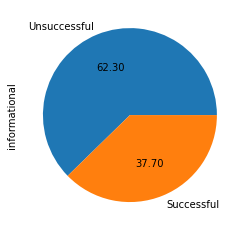

In [52]:
info_received.groupby('successful_offer').count().event.plot.pie( ylabel="informational",figsize=(4, 4),autopct="%.2f",labels=['Unsuccessful','Successful'])

<font size=4> Informational Offers have been classed<font/>

<font size=4>Classifying BOGO & Discount Offers<font/>

In [53]:
portfolio

,reward,channels,difficulty,duration,offer_type,offer_id
0,10,"[mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,[web],20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [54]:
#all non-informational offers can be treated the same when we 
bogo_discount_offers=list(portfolio[(portfolio.offer_type.isin(['bogo','discount']))].offer_id)
display(bogo_discount_offers)

['ae264e3637204a6fb9bb56bc8210ddfd',
 '4d5c57ea9a6940dd891ad53e9dbe8da0',
 '9b98b8c7a33c4b65b9aebfe6a799e6d9',
 '0b1e1539f2cc45b7b9fa7c272da2e1d7',
 '2298d6c36e964ae4a3e7e9706d1fb8c2',
 'fafdcd668e3743c1bb461111dcafc2a4',
 'f19421c1d4aa40978ebb69ca19b0e20d',
 '2906b810c7d4411798c6938adc9daaa5']

In [55]:
bogo_discount_data=transcript_portfolio[transcript_portfolio['offer_id'].isin(bogo_discount_offers)]
print('number of combined BOGO and discount records is: {}'.format(len(bogo_discount_data)))


number of combined BOGO and discount records is: 248624


set a completed offer to be a successful offer if the time it occurs is less than the expiry time (that is the time associated with the last viewed offer)

In [56]:
bogo_discount_data_complete=bogo_discount_data[bogo_discount_data['event']=='offer completed']


In [57]:
bogo_discount_data_complete['successful_offer']=np.where(bogo_discount_data_complete['time']<bogo_discount_data_complete['expiry'],1,0)


In [58]:
bogo_discount_data=bogo_discount_data.join(bogo_discount_data_complete['successful_offer'])

In [59]:
bogo_discount_data.head()

,person,event,time,offer_id,amount,reward,channels,difficulty,duration,offer_type,expiry,successful_offer
153401,0009655768c64bdeb2e877511632db8f,offer received,408,f19421c1d4aa40978ebb69ca19b0e20d,NaN,5.0,"[web, mobile, social]",5.0,5.0,bogo,528.0,NaN
168413,0009655768c64bdeb2e877511632db8f,offer completed,414,f19421c1d4aa40978ebb69ca19b0e20d,NaN,5.0,"[web, mobile, social]",5.0,5.0,bogo,NaN,0.0
187554,0009655768c64bdeb2e877511632db8f,offer viewed,456,f19421c1d4aa40978ebb69ca19b0e20d,NaN,5.0,"[web, mobile, social]",5.0,5.0,bogo,528.0,NaN
204340,0009655768c64bdeb2e877511632db8f,offer received,504,fafdcd668e3743c1bb461111dcafc2a4,NaN,2.0,"[web, mobile, social]",10.0,10.0,discount,744.0,NaN
228422,0009655768c64bdeb2e877511632db8f,transaction,528,f19421c1d4aa40978ebb69ca19b0e20d,14.11,5.0,"[web, mobile, social]",5.0,5.0,bogo,528.0,NaN


it is possible that a person can have 2 offers open at the same time and have them both completed by a single purchase.
See
* person : 0011e0d4e6b944f998e987f904e8c1e5
* offer : 0b1e1539f2cc45b7b9fa7c272da2e1d7 & 9b98b8c7a33c4b65b9aebfe6a799e6d9
* transaction occured at 576
* both offers were both still live (and both had been viewed) so both got correctly marked as completed.

And i dont think it makes sense in this instance to infer that it was the latter offer that influenced the customer more than the first. The first offer gave the customer 10 days to spent 20 dollars. Perhaps the customer was always planning on activating that offer within the 10 day period. Or perhaps it was the combination of the two offers that persuaded the customer to go back to start starbucks and purchase something to complete the pair of offers. It is one of many edge cases in this data. And a different data analyst might make a different call. But I will leave both as successful offers.

In [60]:
bogo_discount_data[bogo_discount_data.person=='0011e0d4e6b944f998e987f904e8c1e5'].tail(9).head(7).drop(['channels','difficulty','duration','reward'], axis=1)

,person,event,time,offer_id,amount,offer_type,expiry,successful_offer
153697,0011e0d4e6b944f998e987f904e8c1e5,offer received,408,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,discount,648.0,NaN
177937,0011e0d4e6b944f998e987f904e8c1e5,offer viewed,432,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,discount,648.0,NaN
204643,0011e0d4e6b944f998e987f904e8c1e5,offer received,504,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,bogo,672.0,NaN
222679,0011e0d4e6b944f998e987f904e8c1e5,offer viewed,516,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,bogo,672.0,NaN
258979,0011e0d4e6b944f998e987f904e8c1e5,transaction,576,9b98b8c7a33c4b65b9aebfe6a799e6d9,22.05,bogo,672.0,NaN
258980,0011e0d4e6b944f998e987f904e8c1e5,offer completed,576,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,discount,648.0,1.0
258981,0011e0d4e6b944f998e987f904e8c1e5,offer completed,576,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,bogo,672.0,1.0


so now I will do the same step as before. I will do a reverse fill successful_offer on offer viewed columns. 



Now I have all the completed offers that correspond to a successful offer. So I want to backfill the successful_offer column to the viewed events first. And then I will backfill the viewed events to offer received.

The reason I do it in two steps is to avoid certain edge cases. Where the same user gets the same offer twice. And if only the second one is successful, I dont want all previous ones classed as successful, just the latter one.

An example of the case I will be avoiding is this ( same offer type and same person all occuring within a small time frame):
* Received
* Viewed
* Received 
* Transaction  
* Completed : True

The completed offer will be marked as 1b and be associated with the first recieved offers. If i were to backfill all at once, then both received offers will be classed as successful. But by first backfilling on viewed and then backfilling viewed on received I end up with this:
* Received :True
* Viewed : True
* Received :False
* Transaction  
* Completed : True

as expected.

I might change the 2nd step here. So first backfill transactions to viewed. And then filter just on received and filtered and use the shift function. This would also fix this edge case (again the rare possibility that the same user received the same offer within a short time frame):

* Received : False
* Received :True
* Viewed : True
* Received :False
* Transaction  
* Completed : True


as expected.  


I will then just select the received events from the table as these are the values ill be entering into my machine learning mode.

In [61]:
cols=['person','offer_id','successful_offer']

backfilling completed offers "successful offer" column to offer viewed

In [62]:
bogo_discount_data_view_comp=bogo_discount_data[(bogo_discount_data.event == 'offer viewed')|(bogo_discount_data.event == 'offer completed')].loc[:,cols].groupby(['person','offer_id']).bfill()
bogo_discount_data.update(bogo_discount_data_view_comp)


Shift the successful offers up one (more robust solution for edge cases than the one above)

In [63]:
bogo_discount_data_view_rec=bogo_discount_data[(bogo_discount_data.event.isin(['offer viewed','offer received']))]
bogo_discount_data_view_rec.head(5)

,person,event,time,offer_id,amount,reward,channels,difficulty,duration,offer_type,expiry,successful_offer
153401,0009655768c64bdeb2e877511632db8f,offer received,408,f19421c1d4aa40978ebb69ca19b0e20d,NaN,5.0,"[web, mobile, social]",5.0,5.0,bogo,528.0,NaN
187554,0009655768c64bdeb2e877511632db8f,offer viewed,456,f19421c1d4aa40978ebb69ca19b0e20d,NaN,5.0,"[web, mobile, social]",5.0,5.0,bogo,528.0,NaN
204340,0009655768c64bdeb2e877511632db8f,offer received,504,fafdcd668e3743c1bb461111dcafc2a4,NaN,2.0,"[web, mobile, social]",10.0,10.0,discount,744.0,NaN
233413,0009655768c64bdeb2e877511632db8f,offer viewed,540,fafdcd668e3743c1bb461111dcafc2a4,NaN,2.0,"[web, mobile, social]",10.0,10.0,discount,744.0,NaN
247879,0009655768c64bdeb2e877511632db8f,offer received,576,2906b810c7d4411798c6938adc9daaa5,NaN,2.0,"[web, mobile]",10.0,7.0,discount,744.0,NaN


In [64]:
#offers_viewed_transactions_completed['successful_offer'] = 
bogo_discount_data_view_rec['successful_offer']=bogo_discount_data_view_rec.groupby(['person','offer_id'])['successful_offer'].shift(periods=-1)



In [65]:
bogo_discount_data.update(bogo_discount_data_view_rec)

In [66]:
bogo_discount_data.head()
#bogo_discount_data.head(35)

,person,event,time,offer_id,amount,reward,channels,difficulty,duration,offer_type,expiry,successful_offer
153401,0009655768c64bdeb2e877511632db8f,offer received,408.0,f19421c1d4aa40978ebb69ca19b0e20d,NaN,5.0,"[web, mobile, social]",5.0,5.0,bogo,528.0,NaN
168413,0009655768c64bdeb2e877511632db8f,offer completed,414.0,f19421c1d4aa40978ebb69ca19b0e20d,NaN,5.0,"[web, mobile, social]",5.0,5.0,bogo,NaN,0.0
187554,0009655768c64bdeb2e877511632db8f,offer viewed,456.0,f19421c1d4aa40978ebb69ca19b0e20d,NaN,5.0,"[web, mobile, social]",5.0,5.0,bogo,528.0,NaN
204340,0009655768c64bdeb2e877511632db8f,offer received,504.0,fafdcd668e3743c1bb461111dcafc2a4,NaN,2.0,"[web, mobile, social]",10.0,10.0,discount,744.0,NaN
228422,0009655768c64bdeb2e877511632db8f,transaction,528.0,f19421c1d4aa40978ebb69ca19b0e20d,14.11,5.0,"[web, mobile, social]",5.0,5.0,bogo,528.0,NaN


In [67]:
bogo_discount_received=bogo_discount_data[bogo_discount_data['event']=='offer received']


In [68]:
bogo_discount_received['successful_offer']=bogo_discount_received['successful_offer'].fillna(0)
bogo_discount_received.head()

,person,event,time,offer_id,amount,reward,channels,difficulty,duration,offer_type,expiry,successful_offer
153401,0009655768c64bdeb2e877511632db8f,offer received,408.0,f19421c1d4aa40978ebb69ca19b0e20d,NaN,5.0,"[web, mobile, social]",5.0,5.0,bogo,528.0,0.0
204340,0009655768c64bdeb2e877511632db8f,offer received,504.0,fafdcd668e3743c1bb461111dcafc2a4,NaN,2.0,"[web, mobile, social]",10.0,10.0,discount,744.0,0.0
247879,0009655768c64bdeb2e877511632db8f,offer received,576.0,2906b810c7d4411798c6938adc9daaa5,NaN,2.0,"[web, mobile]",10.0,7.0,discount,744.0,0.0
56475,00116118485d4dfda04fdbaba9a87b5c,offer received,168.0,f19421c1d4aa40978ebb69ca19b0e20d,NaN,5.0,"[web, mobile, social]",5.0,5.0,bogo,288.0,0.0
248359,00116118485d4dfda04fdbaba9a87b5c,offer received,576.0,f19421c1d4aa40978ebb69ca19b0e20d,NaN,5.0,"[web, mobile, social]",5.0,5.0,bogo,696.0,0.0


In [69]:
bogo_discount_received.groupby(['successful_offer','offer_type']).count().event.unstack()

offer_type,bogo,discount
successful_offer,,
0.0,19032,17627
1.0,11467,12916


Similar to the informational offers, the split is close to 60:40. Which is a very nicely balanced data set.

array([<AxesSubplot:ylabel='bogo'>, <AxesSubplot:ylabel='discount'>],
      dtype=object)

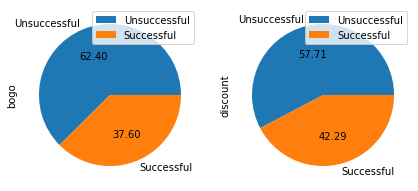

In [70]:
bogo_discount_received.groupby(['successful_offer','offer_type']).count().event.unstack().plot.pie( subplots=True,figsize=(7, 7),autopct="%.2f",labels=['Unsuccessful','Successful'])

Joining all the offers received (showing their class) in the one table

In [71]:
offers_received = pd.concat([info_received,bogo_discount_received]).sort_values(['person','time'])

reindexing the table (for no real reason)  

Decided to hold off on this, because near the end I add on extra parameters (accumulative spend to date)

In [72]:

#offers_received=offers_received.reset_index().drop(columns=['index'])

In [73]:
offers_received.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76277 entries, 55972 to 246495
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   person            76277 non-null  object 
 1   event             76277 non-null  object 
 2   time              76277 non-null  float64
 3   offer_id          76277 non-null  object 
 4   amount            0 non-null      float64
 5   reward            76277 non-null  float64
 6   channels          76277 non-null  object 
 7   difficulty        76277 non-null  float64
 8   duration          76277 non-null  float64
 9   offer_type        76277 non-null  object 
 10  expiry            76277 non-null  float64
 11  successful_offer  76277 non-null  float64
dtypes: float64(7), object(5)
memory usage: 7.6+ MB


Will drop amount from the table. It only contains nulls for offer received events. also dropping ~expiry as it will no longer be needed. Dropping event because they are all now equal to offer receieved.

In [74]:
offers_received=offers_received.drop(columns=['event','amount','expiry'])

In [75]:
offers_received

,person,time,offer_id,reward,channels,difficulty,duration,offer_type,successful_offer
55972,0009655768c64bdeb2e877511632db8f,168.0,5a8bc65990b245e5a138643cd4eb9837,0.0,"[mobile, social]",0.0,3.0,informational,1.0
113605,0009655768c64bdeb2e877511632db8f,336.0,3f207df678b143eea3cee63160fa8bed,0.0,"[web, mobile]",0.0,4.0,informational,1.0
153401,0009655768c64bdeb2e877511632db8f,408.0,f19421c1d4aa40978ebb69ca19b0e20d,5.0,"[web, mobile, social]",5.0,5.0,bogo,0.0
204340,0009655768c64bdeb2e877511632db8f,504.0,fafdcd668e3743c1bb461111dcafc2a4,2.0,"[web, mobile, social]",10.0,10.0,discount,0.0
247879,0009655768c64bdeb2e877511632db8f,576.0,2906b810c7d4411798c6938adc9daaa5,2.0,"[web, mobile]",10.0,7.0,discount,0.0
...,...,...,...,...,...,...,...,...,...
54574,ffff82501cea40309d5fdd7edcca4a07,168.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0,[web],20.0,10.0,discount,1.0
112214,ffff82501cea40309d5fdd7edcca4a07,336.0,2906b810c7d4411798c6938adc9daaa5,2.0,"[web, mobile]",10.0,7.0,discount,1.0
152030,ffff82501cea40309d5fdd7edcca4a07,408.0,2906b810c7d4411798c6938adc9daaa5,2.0,"[web, mobile]",10.0,7.0,discount,1.0
202962,ffff82501cea40309d5fdd7edcca4a07,504.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,"[web, mobile]",5.0,7.0,bogo,0.0


array([<AxesSubplot:ylabel='bogo'>, <AxesSubplot:ylabel='discount'>,
       <AxesSubplot:ylabel='informational'>], dtype=object)

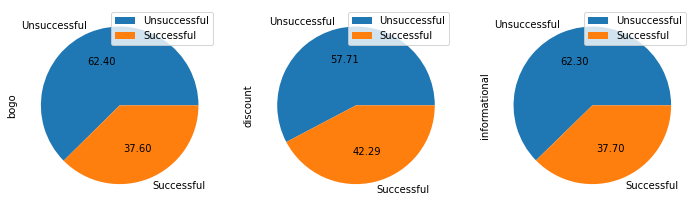

In [76]:
offers_received.groupby(['successful_offer','offer_type']).count().reward.unstack().plot.pie( subplots=True,autopct="%.2f",figsize=(12, 12),labels=['Unsuccessful','Successful'])

The Discount offers are more successful than bogo and informational

<font size=5>One Hot Encoding<font/>

I had originally done the one hot encoding and scaling before the classification. But I found it trickier to confirm that my logic was working as I expected. So I decided to do it after classifying.

 <font size="4"> portfolio </font>

Splitting the channel feature apart.

In [77]:
channels = pd.DataFrame(offers_received.pop('channels'))

Steps below almost work likes a one hot encoding for nested values.  

explode behaves like an ungrouping:  
https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.explode.html

In [78]:
channels = channels.explode('channels')

In [79]:
channels = channels.assign(value= 1)

https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.pivot.html

In [80]:
channels=channels.pivot(columns='channels', values='value')

In [81]:
channels.fillna(value=0, inplace=True)

In [82]:
channels

channels,mobile,social,web
0,1.0,0.0,1.0
1,0.0,0.0,1.0
2,1.0,0.0,1.0
3,1.0,1.0,1.0
4,1.0,1.0,1.0
...,...,...,...
257882,1.0,1.0,0.0
257883,1.0,0.0,1.0
257884,1.0,1.0,1.0
257885,1.0,1.0,0.0


In [83]:
offers_received = offers_received.join(channels)
del channels

In [84]:
offers_received

,person,time,offer_id,reward,difficulty,duration,offer_type,successful_offer,mobile,social,web
55972,0009655768c64bdeb2e877511632db8f,168.0,5a8bc65990b245e5a138643cd4eb9837,0.0,0.0,3.0,informational,1.0,1.0,1.0,0.0
113605,0009655768c64bdeb2e877511632db8f,336.0,3f207df678b143eea3cee63160fa8bed,0.0,0.0,4.0,informational,1.0,1.0,0.0,1.0
153401,0009655768c64bdeb2e877511632db8f,408.0,f19421c1d4aa40978ebb69ca19b0e20d,5.0,5.0,5.0,bogo,0.0,1.0,1.0,1.0
204340,0009655768c64bdeb2e877511632db8f,504.0,fafdcd668e3743c1bb461111dcafc2a4,2.0,10.0,10.0,discount,0.0,1.0,1.0,1.0
247879,0009655768c64bdeb2e877511632db8f,576.0,2906b810c7d4411798c6938adc9daaa5,2.0,10.0,7.0,discount,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
54574,ffff82501cea40309d5fdd7edcca4a07,168.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0,20.0,10.0,discount,1.0,0.0,0.0,1.0
112214,ffff82501cea40309d5fdd7edcca4a07,336.0,2906b810c7d4411798c6938adc9daaa5,2.0,10.0,7.0,discount,1.0,1.0,0.0,1.0
152030,ffff82501cea40309d5fdd7edcca4a07,408.0,2906b810c7d4411798c6938adc9daaa5,2.0,10.0,7.0,discount,1.0,1.0,0.0,1.0
202962,ffff82501cea40309d5fdd7edcca4a07,504.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,5.0,7.0,bogo,0.0,1.0,0.0,1.0


now one hot encode the offer_type

In [85]:
#function to one hot encode a field and join to its table
#def one_hot(df,col):
#    df=pd.concat([df[:],pd.get_dummies(df[col],prefix=col)],axis=1)
#    df=df.drop(columns=col,axis=1)
#    return df

In [86]:
#function to one hot encode a field and join to its table (same result as above)
def one_hot(df,col):
    df = df.join(pd.get_dummies(df.pop(col),prefix=col))
    return df

In [87]:
offers_received=one_hot(offers_received,'offer_type')
offers_received

,person,time,offer_id,reward,difficulty,duration,successful_offer,mobile,social,web,offer_type_bogo,offer_type_discount,offer_type_informational
55972,0009655768c64bdeb2e877511632db8f,168.0,5a8bc65990b245e5a138643cd4eb9837,0.0,0.0,3.0,1.0,1.0,1.0,0.0,0,0,1
113605,0009655768c64bdeb2e877511632db8f,336.0,3f207df678b143eea3cee63160fa8bed,0.0,0.0,4.0,1.0,1.0,0.0,1.0,0,0,1
153401,0009655768c64bdeb2e877511632db8f,408.0,f19421c1d4aa40978ebb69ca19b0e20d,5.0,5.0,5.0,0.0,1.0,1.0,1.0,1,0,0
204340,0009655768c64bdeb2e877511632db8f,504.0,fafdcd668e3743c1bb461111dcafc2a4,2.0,10.0,10.0,0.0,1.0,1.0,1.0,0,1,0
247879,0009655768c64bdeb2e877511632db8f,576.0,2906b810c7d4411798c6938adc9daaa5,2.0,10.0,7.0,0.0,1.0,0.0,1.0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
54574,ffff82501cea40309d5fdd7edcca4a07,168.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0,20.0,10.0,1.0,0.0,0.0,1.0,0,1,0
112214,ffff82501cea40309d5fdd7edcca4a07,336.0,2906b810c7d4411798c6938adc9daaa5,2.0,10.0,7.0,1.0,1.0,0.0,1.0,0,1,0
152030,ffff82501cea40309d5fdd7edcca4a07,408.0,2906b810c7d4411798c6938adc9daaa5,2.0,10.0,7.0,1.0,1.0,0.0,1.0,0,1,0
202962,ffff82501cea40309d5fdd7edcca4a07,504.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,5.0,7.0,0.0,1.0,0.0,1.0,1,0,0


Now I need to prepare the profile table.  

This will involve parsing the became_member_on field to be a number.  
I will also one hot encode the gender field.  
I will remove the rows with missing values for income, age and gender.
I may also scale the age variable because it is close to a normal distribution already so it wont be required to do some quantile scaling.

In [88]:
#profile.age.hist(bins=84)

In [89]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


parsing became_member_on

In [90]:
profile['became_member_on']=pd.to_datetime(profile['became_member_on'], format='%Y%m%d')

In [91]:
profile['became_member_on']=profile['became_member_on'].view('int')

I will join profile table to the offer_received table before removing the values with the bad data.

In [92]:
profile.rename(columns={"id": "person"},inplace=True)

In [93]:
offers_received

,person,time,offer_id,reward,difficulty,duration,successful_offer,mobile,social,web,offer_type_bogo,offer_type_discount,offer_type_informational
55972,0009655768c64bdeb2e877511632db8f,168.0,5a8bc65990b245e5a138643cd4eb9837,0.0,0.0,3.0,1.0,1.0,1.0,0.0,0,0,1
113605,0009655768c64bdeb2e877511632db8f,336.0,3f207df678b143eea3cee63160fa8bed,0.0,0.0,4.0,1.0,1.0,0.0,1.0,0,0,1
153401,0009655768c64bdeb2e877511632db8f,408.0,f19421c1d4aa40978ebb69ca19b0e20d,5.0,5.0,5.0,0.0,1.0,1.0,1.0,1,0,0
204340,0009655768c64bdeb2e877511632db8f,504.0,fafdcd668e3743c1bb461111dcafc2a4,2.0,10.0,10.0,0.0,1.0,1.0,1.0,0,1,0
247879,0009655768c64bdeb2e877511632db8f,576.0,2906b810c7d4411798c6938adc9daaa5,2.0,10.0,7.0,0.0,1.0,0.0,1.0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
54574,ffff82501cea40309d5fdd7edcca4a07,168.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0,20.0,10.0,1.0,0.0,0.0,1.0,0,1,0
112214,ffff82501cea40309d5fdd7edcca4a07,336.0,2906b810c7d4411798c6938adc9daaa5,2.0,10.0,7.0,1.0,1.0,0.0,1.0,0,1,0
152030,ffff82501cea40309d5fdd7edcca4a07,408.0,2906b810c7d4411798c6938adc9daaa5,2.0,10.0,7.0,1.0,1.0,0.0,1.0,0,1,0
202962,ffff82501cea40309d5fdd7edcca4a07,504.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,5.0,7.0,0.0,1.0,0.0,1.0,1,0,0


In [94]:
final_table=offers_received.merge(profile)

In [95]:
final_table

,person,time,offer_id,reward,difficulty,duration,successful_offer,mobile,social,web,offer_type_bogo,offer_type_discount,offer_type_informational,gender,age,became_member_on,income
0,0009655768c64bdeb2e877511632db8f,168.0,5a8bc65990b245e5a138643cd4eb9837,0.0,0.0,3.0,1.0,1.0,1.0,0.0,0,0,1,M,33,1492732800000000000,72000.0
1,0009655768c64bdeb2e877511632db8f,336.0,3f207df678b143eea3cee63160fa8bed,0.0,0.0,4.0,1.0,1.0,0.0,1.0,0,0,1,M,33,1492732800000000000,72000.0
2,0009655768c64bdeb2e877511632db8f,408.0,f19421c1d4aa40978ebb69ca19b0e20d,5.0,5.0,5.0,0.0,1.0,1.0,1.0,1,0,0,M,33,1492732800000000000,72000.0
3,0009655768c64bdeb2e877511632db8f,504.0,fafdcd668e3743c1bb461111dcafc2a4,2.0,10.0,10.0,0.0,1.0,1.0,1.0,0,1,0,M,33,1492732800000000000,72000.0
4,0009655768c64bdeb2e877511632db8f,576.0,2906b810c7d4411798c6938adc9daaa5,2.0,10.0,7.0,0.0,1.0,0.0,1.0,0,1,0,M,33,1492732800000000000,72000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76272,ffff82501cea40309d5fdd7edcca4a07,168.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0,20.0,10.0,1.0,0.0,0.0,1.0,0,1,0,F,45,1480032000000000000,62000.0
76273,ffff82501cea40309d5fdd7edcca4a07,336.0,2906b810c7d4411798c6938adc9daaa5,2.0,10.0,7.0,1.0,1.0,0.0,1.0,0,1,0,F,45,1480032000000000000,62000.0
76274,ffff82501cea40309d5fdd7edcca4a07,408.0,2906b810c7d4411798c6938adc9daaa5,2.0,10.0,7.0,1.0,1.0,0.0,1.0,0,1,0,F,45,1480032000000000000,62000.0
76275,ffff82501cea40309d5fdd7edcca4a07,504.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,5.0,7.0,0.0,1.0,0.0,1.0,1,0,0,F,45,1480032000000000000,62000.0


filtering out bad data from profile.  

in the data exploration notebook we discovered all rows where age=118 are also the same rows where both gender and income are null. So I will remove those rows.

In [96]:
final_table=final_table[final_table['age']!= 118]
#final_table.count()

One hot encode gender

In [97]:
final_table

,person,time,offer_id,reward,difficulty,duration,successful_offer,mobile,social,web,offer_type_bogo,offer_type_discount,offer_type_informational,gender,age,became_member_on,income
0,0009655768c64bdeb2e877511632db8f,168.0,5a8bc65990b245e5a138643cd4eb9837,0.0,0.0,3.0,1.0,1.0,1.0,0.0,0,0,1,M,33,1492732800000000000,72000.0
1,0009655768c64bdeb2e877511632db8f,336.0,3f207df678b143eea3cee63160fa8bed,0.0,0.0,4.0,1.0,1.0,0.0,1.0,0,0,1,M,33,1492732800000000000,72000.0
2,0009655768c64bdeb2e877511632db8f,408.0,f19421c1d4aa40978ebb69ca19b0e20d,5.0,5.0,5.0,0.0,1.0,1.0,1.0,1,0,0,M,33,1492732800000000000,72000.0
3,0009655768c64bdeb2e877511632db8f,504.0,fafdcd668e3743c1bb461111dcafc2a4,2.0,10.0,10.0,0.0,1.0,1.0,1.0,0,1,0,M,33,1492732800000000000,72000.0
4,0009655768c64bdeb2e877511632db8f,576.0,2906b810c7d4411798c6938adc9daaa5,2.0,10.0,7.0,0.0,1.0,0.0,1.0,0,1,0,M,33,1492732800000000000,72000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76272,ffff82501cea40309d5fdd7edcca4a07,168.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0,20.0,10.0,1.0,0.0,0.0,1.0,0,1,0,F,45,1480032000000000000,62000.0
76273,ffff82501cea40309d5fdd7edcca4a07,336.0,2906b810c7d4411798c6938adc9daaa5,2.0,10.0,7.0,1.0,1.0,0.0,1.0,0,1,0,F,45,1480032000000000000,62000.0
76274,ffff82501cea40309d5fdd7edcca4a07,408.0,2906b810c7d4411798c6938adc9daaa5,2.0,10.0,7.0,1.0,1.0,0.0,1.0,0,1,0,F,45,1480032000000000000,62000.0
76275,ffff82501cea40309d5fdd7edcca4a07,504.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,5.0,7.0,0.0,1.0,0.0,1.0,1,0,0,F,45,1480032000000000000,62000.0


In [98]:
final_table=one_hot(final_table,'gender')

In [99]:
final_table.head()

,person,time,offer_id,reward,difficulty,duration,successful_offer,mobile,social,web,offer_type_bogo,offer_type_discount,offer_type_informational,age,became_member_on,income,gender_F,gender_M,gender_O
0,0009655768c64bdeb2e877511632db8f,168.0,5a8bc65990b245e5a138643cd4eb9837,0.0,0.0,3.0,1.0,1.0,1.0,0.0,0,0,1,33,1492732800000000000,72000.0,0,1,0
1,0009655768c64bdeb2e877511632db8f,336.0,3f207df678b143eea3cee63160fa8bed,0.0,0.0,4.0,1.0,1.0,0.0,1.0,0,0,1,33,1492732800000000000,72000.0,0,1,0
2,0009655768c64bdeb2e877511632db8f,408.0,f19421c1d4aa40978ebb69ca19b0e20d,5.0,5.0,5.0,0.0,1.0,1.0,1.0,1,0,0,33,1492732800000000000,72000.0,0,1,0
3,0009655768c64bdeb2e877511632db8f,504.0,fafdcd668e3743c1bb461111dcafc2a4,2.0,10.0,10.0,0.0,1.0,1.0,1.0,0,1,0,33,1492732800000000000,72000.0,0,1,0
4,0009655768c64bdeb2e877511632db8f,576.0,2906b810c7d4411798c6938adc9daaa5,2.0,10.0,7.0,0.0,1.0,0.0,1.0,0,1,0,33,1492732800000000000,72000.0,0,1,0


age is close to a normal distribution

array([[<AxesSubplot:title={'center':'became_member_on'}>,
        <AxesSubplot:title={'center':'income'}>],
       [<AxesSubplot:title={'center':'age'}>, <AxesSubplot:>]],
      dtype=object)

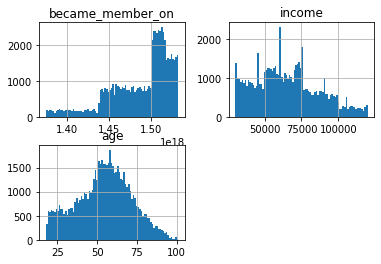

In [100]:
final_table[['became_member_on','income','age']][final_table['age'] !=118].hist(bins=84)

Do not use quantile_transform unless you know what you are doing. A common mistake is to apply it to the entire data before splitting into training and test sets. This will bias the model evaluation because information would have leaked from the test set to the training set. In general, we recommend using QuantileTransformer within a Pipeline in order to prevent most risks of data leaking:pipe = make_pipeline(QuantileTransformer(), LogisticRegression()).

Robust Scaler: similar to normalization but it instead uses the interquartile range, so that it is robust to outliers.  
Robust Scaler: doesn't take the median into account and only focuses on the parts where the bulk data is.  
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.robust_scale.html

Standardization: scales features such that the distribution is centered around 0, with a standard deviation of 1.  
Standardization: not good if the data is not normally distributed (i.e. no Gaussian Distribution).  
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.scale.html

Quantile Scaler: This method transforms the features to follow a uniform or a normal distribution. Therefore, for a given feature, this transformation tends to spread out the most frequent values. It also reduces the impact of (marginal) outliers: this is therefore a robust preprocessing scheme.  
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.QuantileTransformer.html#sklearn.preprocessing.QuantileTransformer  
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.quantile_transform.html#sklearn.preprocessing.quantile_transform

Power transforms: are a family of parametric, monotonic transformations that are applied to make data more Gaussian-like. This is useful for modeling issues related to heteroscedasticity (non-constant variance), or other situations where normality is desired.  
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.power_transform.html#sklearn.preprocessing.power_transform

This estimator scales and translates each feature individually such that it is in the given range on the training set, i.e. between zero and one  
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.minmax_scale.html#sklearn.preprocessing.minmax_scale

Quantile is good for outliers  
Power is good for non-constant variance

In [101]:
def robustScale (df,col):
    col=df.pop(col)
    col=pd.DataFrame(col)
    col_scaled=robust_scale(col, copy=False)
    col = pd.DataFrame(col_scaled, columns=col.columns, index=col.index)
    df=df.join(col)
    return (df)

In [102]:
def standardScale (df,col):
    col=df.pop(col)
    col=pd.DataFrame(col)
    col_scaled=scale(col, copy=False)
    col = pd.DataFrame(col_scaled, columns=col.columns, index=col.index)
    df=df.join(col)
    return (df)

In [103]:
def quantileScale (df,col):
    col=df.pop(col)
    col=pd.DataFrame(col)
    col_scaled=quantile_transform(col, output_distribution='normal', copy=False)
    col = pd.DataFrame(col_scaled, columns=col.columns, index=col.index)
    df=df.join(col)
    return (df)

In [104]:
def minMaxScale (df,col):
    col=df.pop(col)
    col=pd.DataFrame(col)
    col_scaled=minmax_scale(col, copy=False)
    col = pd.DataFrame(col_scaled, columns=col.columns, index=col.index)
    df=df.join(col)
    return (df)

I will use robust_scale on both 'became_member_on" and "income" because the distrubition isn't that close to a normal distrubition

<font size=4>Scaling Portfolio<font/>

Scaling the reward, difficulty and duration to be between 0 and 1. None of them have a normal distribution, so standard scaling doesnt make sense. And I dont think robust scaling is needed as there arent any obvious outliers.

In [105]:
def minMaxScale (df,col):
    col=df.filter(col)
    col_scaled=minmax_scale(col, copy=False)
    col=pd.DataFrame(col_scaled, columns=col.columns, index=col.index)
    df.update(col)
    return (df)

I was going to use a mixture of scaling for my features.  
* Quantile/robust for 'became_member_on', 'income'
* Scaler for 'age'
* Min-max for 'difficulty', 'reward', 'duration

But from reading the advice on sklearn and other sources it seems adviseable to do Quantile transformations after splitting the data in testing and training. I believe it might also be wise to apply the same transformation upon all features. So I will apply a quantile scaling on all my features within a pipeline after splitting the data for testing and training.

In [106]:
final_table.head()

,person,time,offer_id,reward,difficulty,duration,successful_offer,mobile,social,web,offer_type_bogo,offer_type_discount,offer_type_informational,age,became_member_on,income,gender_F,gender_M,gender_O
0,0009655768c64bdeb2e877511632db8f,168.0,5a8bc65990b245e5a138643cd4eb9837,0.0,0.0,3.0,1.0,1.0,1.0,0.0,0,0,1,33,1492732800000000000,72000.0,0,1,0
1,0009655768c64bdeb2e877511632db8f,336.0,3f207df678b143eea3cee63160fa8bed,0.0,0.0,4.0,1.0,1.0,0.0,1.0,0,0,1,33,1492732800000000000,72000.0,0,1,0
2,0009655768c64bdeb2e877511632db8f,408.0,f19421c1d4aa40978ebb69ca19b0e20d,5.0,5.0,5.0,0.0,1.0,1.0,1.0,1,0,0,33,1492732800000000000,72000.0,0,1,0
3,0009655768c64bdeb2e877511632db8f,504.0,fafdcd668e3743c1bb461111dcafc2a4,2.0,10.0,10.0,0.0,1.0,1.0,1.0,0,1,0,33,1492732800000000000,72000.0,0,1,0
4,0009655768c64bdeb2e877511632db8f,576.0,2906b810c7d4411798c6938adc9daaa5,2.0,10.0,7.0,0.0,1.0,0.0,1.0,0,1,0,33,1492732800000000000,72000.0,0,1,0


Splitting data up into targets and features

In [107]:
final_table.rename({'offer_type_bogo': 'bogo',
                    'offer_type_discount': 'discount',
                    'offer_type_informational': 'informational',
                    'gender_F': 'female',
                    'gender_M': 'male',
                    'gender_O': 'other'}, axis='columns', inplace=True)

In [108]:
final_table.to_pickle("final_table.pkl")

<font size=5>Potential Additional parameters<font/>


* How many transactions (over \\$0.25 each customers had)
* Total spend of each customer (over \\$0.25)
* Total spend of each customer prior to the offer being received (over \\$0.25) (not viewed because that wouldnt be knowledge known really)
* Number of offers a customer received prior to the offer being received (not viewed because that wouldnt be knowledge known really)
* time lag between a previous offer they received and when they viewed it

<font size=4>Total Spent<font/>

transactions less than 25 cents already filtered out.

In [109]:
transcript_portfolio['amount'].min()

0.25

Get the running total of the amount spent by each customer

In [110]:
transcript_portfolio['total_spend']=transcript_portfolio[['amount','person']].groupby('person').cumsum()

In [111]:
transcript_portfolio.head()

,person,event,time,offer_id,amount,reward,channels,difficulty,duration,offer_type,expiry,total_spend
55972,0009655768c64bdeb2e877511632db8f,offer received,168,5a8bc65990b245e5a138643cd4eb9837,NaN,0.0,"[mobile, social]",0.0,3.0,informational,240.0,NaN
77705,0009655768c64bdeb2e877511632db8f,offer viewed,192,5a8bc65990b245e5a138643cd4eb9837,NaN,0.0,"[mobile, social]",0.0,3.0,informational,240.0,NaN
89291,0009655768c64bdeb2e877511632db8f,transaction,228,5a8bc65990b245e5a138643cd4eb9837,22.16,0.0,"[mobile, social]",0.0,3.0,informational,240.0,22.16
113605,0009655768c64bdeb2e877511632db8f,offer received,336,3f207df678b143eea3cee63160fa8bed,NaN,0.0,"[web, mobile]",0.0,4.0,informational,432.0,NaN
139992,0009655768c64bdeb2e877511632db8f,offer viewed,372,3f207df678b143eea3cee63160fa8bed,NaN,0.0,"[web, mobile]",0.0,4.0,informational,432.0,NaN


Fill forward the running total_spend to populate all non-tranaction events

In [112]:
cols=['person','total_spend']

In [113]:
transcript_portfolio['total_spend']=transcript_portfolio.loc[:,cols].groupby(['person']).ffill()

In [114]:
transcript_portfolio['total_spend']=transcript_portfolio['total_spend'].fillna(0)

In [115]:
transcript_portfolio.head()

,person,event,time,offer_id,amount,reward,channels,difficulty,duration,offer_type,expiry,total_spend
55972,0009655768c64bdeb2e877511632db8f,offer received,168,5a8bc65990b245e5a138643cd4eb9837,NaN,0.0,"[mobile, social]",0.0,3.0,informational,240.0,0.00
77705,0009655768c64bdeb2e877511632db8f,offer viewed,192,5a8bc65990b245e5a138643cd4eb9837,NaN,0.0,"[mobile, social]",0.0,3.0,informational,240.0,0.00
89291,0009655768c64bdeb2e877511632db8f,transaction,228,5a8bc65990b245e5a138643cd4eb9837,22.16,0.0,"[mobile, social]",0.0,3.0,informational,240.0,22.16
113605,0009655768c64bdeb2e877511632db8f,offer received,336,3f207df678b143eea3cee63160fa8bed,NaN,0.0,"[web, mobile]",0.0,4.0,informational,432.0,22.16
139992,0009655768c64bdeb2e877511632db8f,offer viewed,372,3f207df678b143eea3cee63160fa8bed,NaN,0.0,"[web, mobile]",0.0,4.0,informational,432.0,22.16


In [116]:
#transcript_portfolio[transcript_portfolio['event']=='offer received'].head()

<font size=4>one_hot encoding to get number of offers/offers viewed<font/>

One hot encode the event variable because I want to get a running total per person by event when an offer is received.

In [117]:
transcript_portfolio=pd.concat([transcript_portfolio[:],pd.get_dummies(transcript_portfolio['event'],prefix=None)],axis=1)

In [118]:
#transcript_portfolio.head()

geting the running total per event by person

In [119]:
#transcript_portfolio['transaction','offer completed','offer received','offer viewed']=
transcript_portfolio.update(transcript_portfolio[['transaction','offer completed','offer received','offer viewed','person']].groupby('person').cumsum())

In [120]:
transcript_portfolio.head()

,person,event,time,offer_id,amount,reward,channels,difficulty,duration,offer_type,expiry,total_spend,offer completed,offer received,offer viewed,transaction
55972,0009655768c64bdeb2e877511632db8f,offer received,168,5a8bc65990b245e5a138643cd4eb9837,NaN,0.0,"[mobile, social]",0.0,3.0,informational,240.0,0.00,0,1,0,0
77705,0009655768c64bdeb2e877511632db8f,offer viewed,192,5a8bc65990b245e5a138643cd4eb9837,NaN,0.0,"[mobile, social]",0.0,3.0,informational,240.0,0.00,0,1,1,0
89291,0009655768c64bdeb2e877511632db8f,transaction,228,5a8bc65990b245e5a138643cd4eb9837,22.16,0.0,"[mobile, social]",0.0,3.0,informational,240.0,22.16,0,1,1,1
113605,0009655768c64bdeb2e877511632db8f,offer received,336,3f207df678b143eea3cee63160fa8bed,NaN,0.0,"[web, mobile]",0.0,4.0,informational,432.0,22.16,0,2,1,1
139992,0009655768c64bdeb2e877511632db8f,offer viewed,372,3f207df678b143eea3cee63160fa8bed,NaN,0.0,"[web, mobile]",0.0,4.0,informational,432.0,22.16,0,2,2,1


In [121]:
new_features=transcript_portfolio.filter(['person','time','offer_id','event','total_spend','transaction','offer completed','offer received','offer viewed'])

Selecting just offer receieved

In [122]:
new_features=new_features.loc[new_features['event']=='offer received']

In [123]:
#reset index (not needed)
#new_features=new_features.reset_index().drop(columns=['index'])

need to join on profile and remove age=118

In [124]:
profile.rename(columns={"id": "person"},inplace=True)

In [125]:
new_features=new_features.merge(profile,on=('person' ),how='left')

In [126]:
new_features=new_features[new_features['age']!= 118]

In [127]:
#making sure I am joining on the correct rows
new_features.filter(['person','offer_id']).equals(final_table.filter(['person','offer_id']))

True

In [128]:
new_features=new_features.filter(['total_spend','transaction','offer completed','offer received','offer viewed'])

In [129]:
final_table_nf=final_table.join(new_features)

In [130]:
#transcript_portfolio[transcript_portfolio.person=='004c5799adbf42868b9cff0396190900'].head(11)
final_table_nf[final_table_nf['person']=='004c5799adbf42868b9cff0396190900'].head()

,person,time,offer_id,reward,difficulty,duration,successful_offer,mobile,social,web,...,became_member_on,income,female,male,other,total_spend,transaction,offer completed,offer received,offer viewed
34,004c5799adbf42868b9cff0396190900,168.0,fafdcd668e3743c1bb461111dcafc2a4,2.0,10.0,10.0,1.0,1.0,1.0,1.0,...,1459382400000000000,99000.0,0,1,0,0.00,0,0,1,0
35,004c5799adbf42868b9cff0396190900,336.0,ae264e3637204a6fb9bb56bc8210ddfd,10.0,10.0,7.0,0.0,1.0,1.0,0.0,...,1459382400000000000,99000.0,0,1,0,95.43,3,1,2,1
36,004c5799adbf42868b9cff0396190900,408.0,f19421c1d4aa40978ebb69ca19b0e20d,5.0,5.0,5.0,1.0,1.0,1.0,1.0,...,1459382400000000000,99000.0,0,1,0,156.18,5,2,3,1
37,004c5799adbf42868b9cff0396190900,504.0,f19421c1d4aa40978ebb69ca19b0e20d,5.0,5.0,5.0,1.0,1.0,1.0,1.0,...,1459382400000000000,99000.0,0,1,0,202.50,7,3,4,2
38,004c5799adbf42868b9cff0396190900,576.0,fafdcd668e3743c1bb461111dcafc2a4,2.0,10.0,10.0,0.0,1.0,1.0,1.0,...,1459382400000000000,99000.0,0,1,0,238.41,8,4,5,3


In [131]:
final_table_nf.rename({'offer completed': 'completed',
                       'offer received': 'received',
                       'offer viewed': 'viewed'}, axis='columns', inplace=True)

In [132]:
final_table_nf.to_pickle("final_table_nf.pkl")

In [133]:
final_table['successful_offer']

0        1.0
1        1.0
2        0.0
3        0.0
4        0.0
        ... 
76272    1.0
76273    1.0
76274    1.0
76275    0.0
76276    0.0
Name: successful_offer, Length: 66501, dtype: float64

In [134]:
final_table['successful_offer']. astype('bool')

0         True
1         True
2        False
3        False
4        False
         ...  
76272     True
76273     True
76274     True
76275    False
76276    False
Name: successful_offer, Length: 66501, dtype: bool

Maybe i should find the people who completed an offer without viewing the offer. Because that was wasted money. (should I include informational offers)